In [1]:
from google.colab import drive
import os
import zipfile

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Đường dẫn đến file zip
zip_path = '/content/drive/MyDrive/Student_Engagement/my_dataset.zip'

# 3. Giải nén vào môi trường Colab
print("Đang giải nén...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/temp_data')
print("Giải nén xong!")

Mounted at /content/drive
Đang giải nén...
Giải nén xong!


In [2]:
# --- CELL 2: CHIA DỮ LIỆU & XÁO TRỘN ---
import os
import shutil
import random
from tqdm import tqdm

# Cấu hình đường dẫn
SOURCE_DIR = '/content/temp_data' # Folder vừa giải nén
DEST_DIR = '/content/final_dataset' # Folder chứa data chuẩn để train
TRAIN_RATIO = 0.8  # 80% Train
VAL_RATIO = 0.1    # 10% Valid (còn lại 10% Test)

def split_dataset(source, dest, train_r, val_r):
    # Tìm folder images và labels (đề phòng file zip có folder con)
    # Code này sẽ quét tìm vị trí chính xác của folder 'images'
    img_source_dir = ""
    lbl_source_dir = ""

    for root, dirs, files in os.walk(source):
        if 'images' in dirs: img_source_dir = os.path.join(root, 'images')
        if 'labels' in dirs: lbl_source_dir = os.path.join(root, 'labels')

    if not img_source_dir or not lbl_source_dir:
        print("❌ LỖI: Không tìm thấy thư mục 'images' hoặc 'labels' trong file giải nén!")
        return

    # Tạo cấu trúc thư mục đích
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(dest, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(dest, 'labels', split), exist_ok=True)

    # Lấy danh sách ảnh
    valid_ext = ('.png', '.jpg', '.jpeg', '.bmp')
    all_imgs = [f for f in os.listdir(img_source_dir) if f.lower().endswith(valid_ext)]
    all_imgs.sort() # Sắp xếp trước

    # XÁO TRỘN (Shuffle) để phá vỡ thứ tự thời gian
    random.seed(42)
    random.shuffle(all_imgs)

    # Tính toán số lượng
    total = len(all_imgs)
    train_end = int(total * train_r)
    val_end = train_end + int(total * val_r)

    print(f"--> Tổng ảnh: {total} | Train: {train_end} | Val: {val_end - train_end} | Test: {total - val_end}")

    # Copy file
    for i, img_name in tqdm(enumerate(all_imgs), total=total, desc="Processing"):
        if i < train_end: split = 'train'
        elif i < val_end: split = 'val'
        else: split = 'test'

        # Logic ghép tên file: Tên ảnh bỏ đuôi -> ghép đuôi .txt
        basename = os.path.splitext(img_name)[0]
        txt_name = basename + ".txt"

        src_img = os.path.join(img_source_dir, img_name)
        src_txt = os.path.join(lbl_source_dir, txt_name)

        if os.path.exists(src_txt):
            shutil.copy(src_img, os.path.join(dest, 'images', split, img_name))
            shutil.copy(src_txt, os.path.join(dest, 'labels', split, txt_name))
        else:
            # print(f"Thiếu label: {img_name}") # Bật lên nếu muốn check lỗi
            pass

    print("\n✅ Đã chia bộ dữ liệu thành công!")

split_dataset(SOURCE_DIR, DEST_DIR, TRAIN_RATIO, VAL_RATIO)

--> Tổng ảnh: 1770 | Train: 1416 | Val: 177 | Test: 177


Processing: 100%|██████████| 1770/1770 [01:02<00:00, 28.10it/s]


✅ Đã chia bộ dữ liệu thành công!


In [3]:
# --- CELL 3: TẠO FILE DATA.YAML ---
yaml_content = """
path: /content/final_dataset
train: images/train
val: images/val
test: images/test

# Số lượng class
nc: 6

# Tên class (Đúng thứ tự bạn đã gán nhãn)
names:
  0: listening
  1: looking_away
  2: sleeping
  3: using_laptop
  4: using_phone
  5: writing
"""

with open('/content/final_dataset/data.yaml', 'w') as f:
    f.write(yaml_content)

print("✅ Đã tạo file data.yaml xong!")

✅ Đã tạo file data.yaml xong!


In [4]:
# --- CELL 4: CÀI ĐẶT & TRAIN ---
# 1. Cài thư viện
!pip install ultralytics

from ultralytics import YOLO

# 2. Load model
model = YOLO('yolov8s.pt')

# 3. Bắt đầu Train
model.train(
    data='/content/final_dataset/data.yaml',
    epochs=50,       # Chạy 50 vòng (có thể tăng lên 100 nếu chưa tốt)
    imgsz=640,       # Kích thước ảnh chuẩn
    batch=16,        # Số ảnh nạp vào mỗi lần học
    patience=10,     # Nếu 10 vòng ko tiến bộ thì tự dừng sớm
    project='/content/drive/MyDrive/KetQua_YOLO_Student',
    name='lan_train_1'
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bf0e5262570>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [5]:
# --- TẢI MODEL best.pt VỀ MÁY ---
from google.colab import files
import os

# 1. Đường dẫn tới file model
model_path = '/content/drive/MyDrive/KetQua_YOLO_Student/lan_train_1/weights/best.pt'

# 2. Kiểm tra xem file có tồn tại
if os.path.exists(model_path):
    print(f"✅ Tìm thấy model tại: {model_path}")
    print("⬇️ Đang bắt đầu tải về máy tính...")
    files.download(model_path)
else:
    print(f"❌ LỖI: Không tìm thấy file tại '{model_path}'")
    print("👉 Hãy vào Google Drive kiểm tra xem folder 'KetQua_YOLO_Student' có file best.pt không nhé.")

✅ Tìm thấy model tại: /content/drive/MyDrive/KetQua_YOLO_Student/lan_train_1/weights/best.pt
⬇️ Đang bắt đầu tải về máy tính...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# --- NÉN VÀ TẢI DATASET ĐÃ CHIA VỀ MÁY ---
import shutil
from google.colab import files
import os

# 1. Cấu hình đường dẫn
folder_to_zip = '/content/final_dataset'  # Thư mục dataset đã chia (train/val/test)
output_filename = '/content/dataset_da_chia_chuan' # Tên file zip đầu ra

# 2. Kiểm tra folder có tồn tại không
if os.path.exists(folder_to_zip):
    print(f"⏳ Đang nén thư mục '{folder_to_zip}' thành file ZIP...")
    print("   (Việc này có thể mất 1-2 phút tùy số lượng ảnh, vui lòng đợi...)")

    # Lệnh nén (tạo file dataset_da_chia_chuan.zip)
    shutil.make_archive(output_filename, 'zip', folder_to_zip)

    print(f"✅ Nén thành công! File nằm tại: {output_filename}.zip")
    print("⬇️ Đang gửi lệnh tải xuống trình duyệt...")

    # Tải file zip về
    files.download(output_filename + '.zip')
else:
    print("❌ LỖI: Không tìm thấy thư mục '/content/final_dataset'.")
    print("👉 Bạn đã chạy đoạn code chia dữ liệu (Split Dataset) ở bước trước chưa?")

⏳ Đang nén thư mục '/content/final_dataset' thành file ZIP...
   (Việc này có thể mất 1-2 phút tùy số lượng ảnh, vui lòng đợi...)
✅ Nén thành công! File nằm tại: /content/dataset_da_chia_chuan.zip
⬇️ Đang gửi lệnh tải xuống trình duyệt...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3381.3±384.6 MB/s, size: 4201.5 KB)
val: Scanning /content/final_dataset/labels/test... 177 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 177/177 127.7it/s 1.4s
val: New cache created: /content/final_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 1.8s/it 21.5s
                   all        177        718      0.982      0.973      0.977      0.952
             listening         98        139      0.975          1      0.989       0.97
          looking_away         97        119      0.991      0.972      0.993      0.934
              sleeping         95        137      0.967      0.868      0.905      0.863
          using_laptop        111        111      0.979          1   

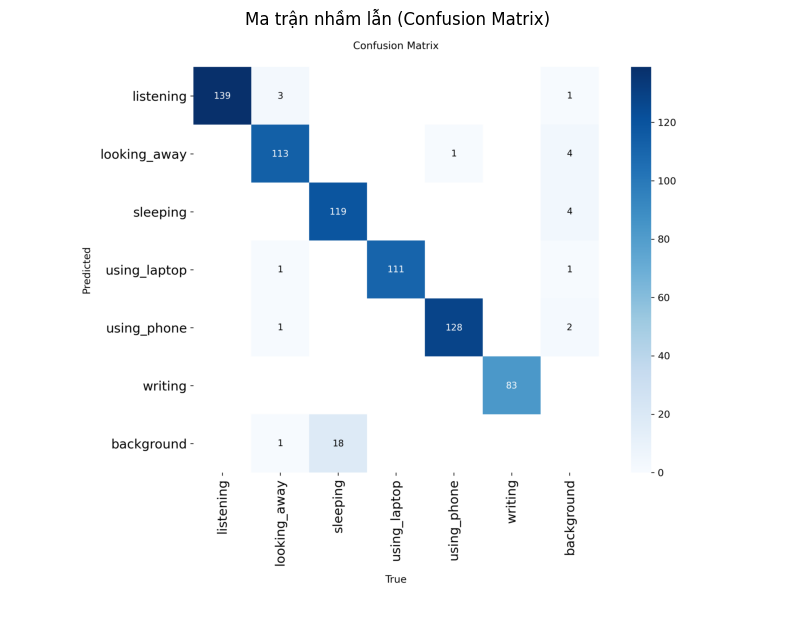

✅ Đã lưu ảnh tại: /content/runs/detect/val/confusion_matrix.png


In [7]:
# --- VẼ MA TRẬN NHẦM LẪN (CONFUSION MATRIX) ---
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import os

# 1. Load model best.pt
model_path = '/content/drive/MyDrive/KetQua_YOLO_Student/lan_train_1/weights/best.pt'
model = YOLO(model_path)

# 2. Chạy Validate trên tập TEST để sinh ra ma trận
# save_dir sẽ là nơi chứa ảnh kết quả
results = model.val(data='/content/final_dataset/data.yaml', split='test', plots=True)
save_dir = results.save_dir # Lấy đường dẫn thư mục vừa chạy xong

# 3. Hiển thị Ma trận nhầm lẫn
confusion_matrix_path = os.path.join(save_dir, 'confusion_matrix.png')

if os.path.exists(confusion_matrix_path):
    img = cv2.imread(confusion_matrix_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Ma trận nhầm lẫn (Confusion Matrix)")
    plt.show()
    print(f"✅ Đã lưu ảnh tại: {confusion_matrix_path}")
else:
    print("❌ Không tìm thấy ảnh Confusion Matrix. Có thể do dataset test quá ít hoặc lỗi phiên bản.")

📊 Bảng 8 biểu đồ quá trình Training:


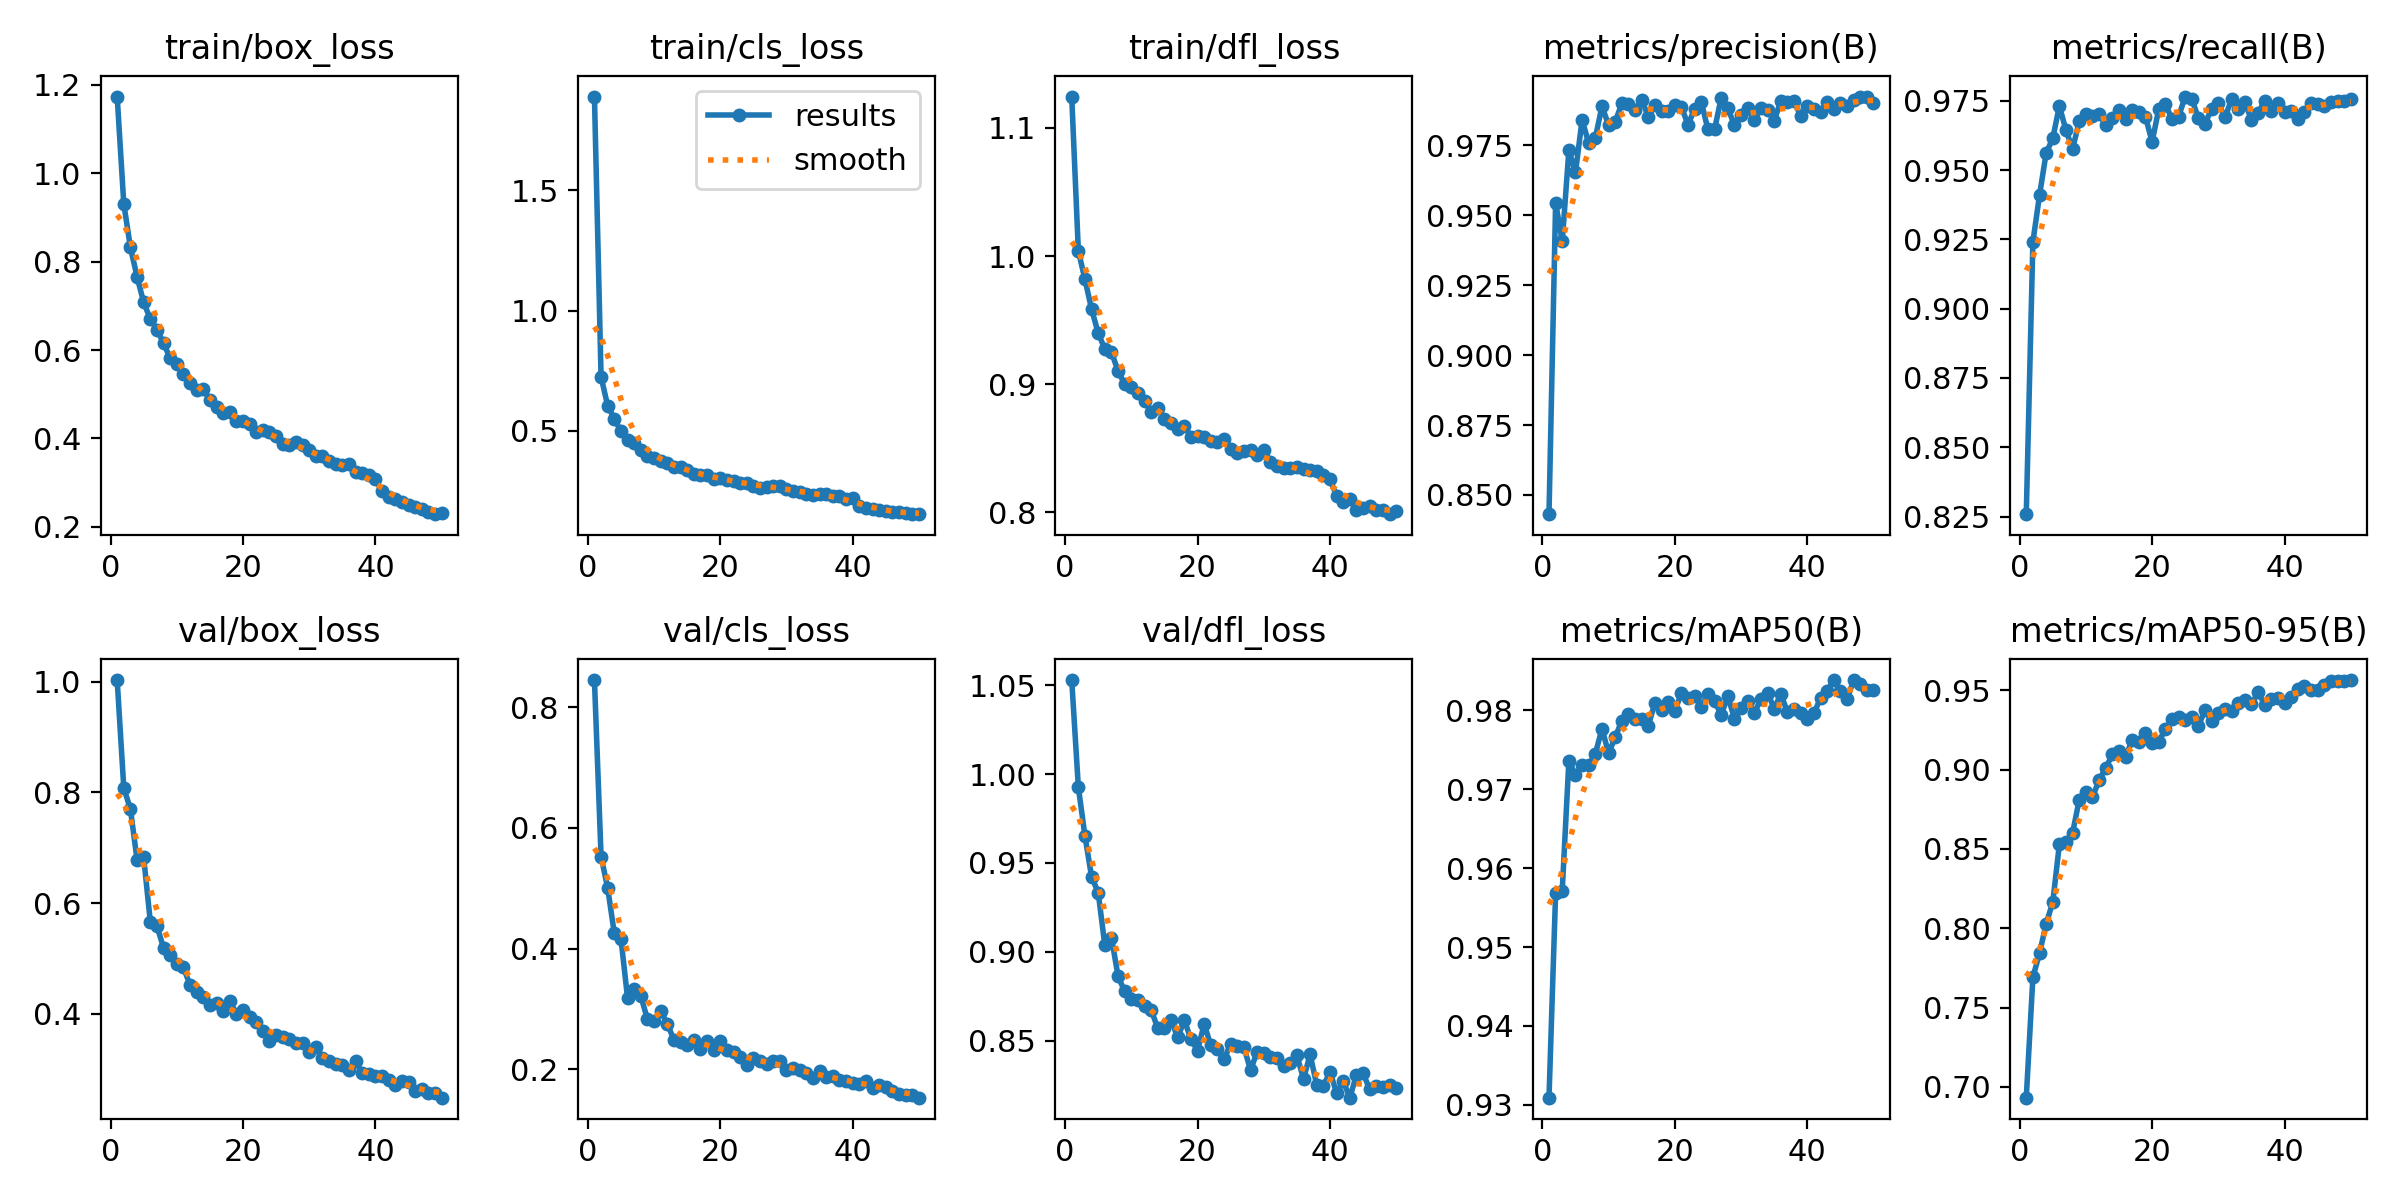

In [8]:
# --- HIỂN THỊ BIỂU ĐỒ QUÁ TRÌNH TRAIN (RESULTS.PNG) ---
from IPython.display import Image, display
import os

# 1. Đường dẫn tới folder kết quả train cũ (lan_train_1)
train_folder = '/content/drive/MyDrive/KetQua_YOLO_Student/lan_train_1'
results_img_path = os.path.join(train_folder, 'results.png')

# 2. Hiển thị
if os.path.exists(results_img_path):
    print("📊 Bảng 8 biểu đồ quá trình Training:")
    display(Image(filename=results_img_path, width=800))

else:
    print(f"❌ Không tìm thấy file 'results.png' tại {train_folder}")
    print("👉 Hãy vào Drive kiểm tra xem model đã train xong chưa.")